# HW4 Multi-Class Classification (Due: Thursday, February 29, 2024, 11:59 PM)

####❗Please submit this notebook (`.ipynb`) with your solutions. The solutions must include the **code**, **explanations** (e.g. *comments*, *figure title, axis labels, and legend*), and the **output of all the cells**. Submitting your solutions without them will lead to `a deduction of points`.

####❗Also, note that you should **cite all the references** you used under each question. Proper referencing is essential for academic integrity, giving credit to original authors, avoiding plagiarism, and providing a traceable path for verification. `Please check the course syllabus for more details about academic integrity`.

####❗Note that you are *not* allowed to use sklearn unless specified by the question.

####❗Please note that the bonus points will be applied to your overall percentage of the course.
---

#### **Q0)** [[0 point]](https://) While you are allowed to discuss homework assignments, it is essential that you write down your code and solutions yourself. If you have discussed the homework with other students, please mention their names.


\##Your answer here

####Please run the cell below to import libraries needed for this HW. Please use the autograd numpy, otherwise you will have issues. Please remember to always use the np library for mathematical functions (e.g., np.log, np.exp, np.sum, etc)

In [35]:
import autograd.numpy as np
from autograd import grad
import matplotlib.pyplot as plt

#### Please load the MNIST digits classification dataset by running the code below. There are 70,000 samples in the dataset where each sample is represented by a 784-dimensional feature vector. (Reference: https://www.openml.org/d/554)




In [36]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


#### Run the code below to divide the data into train/test sets.

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=10000, test_size=2000, random_state=1)
y_train = y_train.astype("int")
y_test = y_test.astype("int")
print(X_train.shape)
print(X_test.shape)

(10000, 784)
(2000, 784)


# $k$ Nearest Neighbors ($k$-NN) Classifier



#### **Q1**) [[30 points]](https://) Implement a $k$-Nearest Neighbors classifier *from scratch*. You are free to code this up in your preferred style. However, make sure that your implementation includes a function that takes an array of feature vectors for the training set, the corresponding class labels, an array of feature vectors for the test set, and the number of nearest neighbors, $k$. The function should return an array of predicted labels for the input test data. Make sure you explain in detail about your implmenetaion.

In [38]:
# after you finish the hw, go back and do this without a loop
def knn_classifier(X_train, y_train, X_test, k, metric="L2"):
  """
  input parameters (All numpy arrays):

    X_train, X_test: n x d matrix where n is the number of training examples in the training set and d is the dimentionality of the features
    y_train: n dim vector with values 0-9 for the ground truth class of the handwritten digit
    k: Hyperparameter representing the number of closest examples in the training dataset we will consider for doing prediction

  output:
    y_pred: for each of the examples in the test set, we will compute the k nearest points from the training set and take a majority vote based on the class of the training examples

  """
  # ensure that all of the inputs are numpy arrays
  X_train = np.array(X_train)
  X_test = np.array(X_test)
  y_train = np.array(y_train)
  y_predicted = [] # array to hold predictions

  # want to compute the distance between each example in X_train and X_test


  # distances = X_train[np.newaxis, :, :] - X_test[:, np.newaxis, :]

  for test_example in X_test: # considering all examples in the test set

    distances = np.sqrt((np.sum((X_train - test_example) ** 2, axis=1))) # compute distance between this test example and all training examples
    closest_k = np.argsort(distances)[:k] # compute the index of the k nearest points in the training set
    votes = y_train[closest_k].astype(int) # get the labels for those k points from the training set and cast them to be integers
    majority_vote = np.argmax(np.bincount(votes)) # compute the mode for the votes and return it
    y_predicted.append(majority_vote) # add the prediction to the list of predictions

  y_pred = np.array(y_predicted)
  
  return y_pred

#### **Q2**) [[15 points]](https://) Implement a function to calcluate the accuracy for a multi-class classification model *from scratch*. Given predicted labels and true labels, your function should return the accuracy.

In [39]:
def calculate_accuracy(y_pred, y_true):
  """
  Function to compute the accuracy between predictions and ground truth labels

  inputs:
    -y_pred: vector of model predictions
    -y_true: vector of ground truth
  
    output:
      -accuracy: floating point number representing how many our model got correct
  """
  y_pred = np.array(y_pred)
  y_true = np.array(y_true).astype(int) # casting type to be int for the labels
  
  accuracy = np.sum(y_pred == y_true)/len(y_pred) # number of equal predictions / total examples

  return accuracy

#### **Q3**) [[5 points]](https://) Given $k$=3, calculate the accuracy of the test set using the function implemented in Q2.


In [40]:
#Your code here
calculate_accuracy(knn_classifier(X_train, y_train, X_test=X_test, k=3), y_test)

0.943

# Naive Bayes Classifier


#### **Q4**) [[60 points]](https://) Implement both a Multinomial Naive Bayes classifier with Laplace smoothing [30 points] and a Gaussian Naive Bayes classifier [30 points] *from scratch*. To prevent everything from becoming zeros, consider adding logs instead of multiplying. You are free to code this up in your preferred style, but you should explain in detail about your implmenetaion.

In [44]:
# Multinomial Naive Bayes w/ smoothing

class NaiveBayesClassifier:

    def __init__(self, X_train, y_train, type="Multinomial") -> None:
        """
        - Constructor for our Naive Bayes classifier.
        - Given the training dataset, we want to construct for each feature (in the MNIST case 784 features which can take values between [0-255] integers) the probability that it 
        takes on a particular value.
        - We wish to construct num_classes of matricies (P0, P1, ... P9) where each matrix (d x num_possible_values) for each of the features where P[i][j] is the probability that 
        feature i gets value j
        - Also want to construct a vector y where y[i] is the number of examples in class i

        inputs:
            - X_train: Training dataset (n x d)
            - y_train: Labels for the training data (n,)

        """
        self.NUM_CLASSES = 10
        NUM_EXAMPLES = len(X_train)
        NUM_FEATURES = X_train.shape[1]

        self.Y_container = []
        self.P = np.zeros((self.NUM_CLASSES, NUM_FEATURES)) # construct probs from counts for this (10 x 784)

        self.Ymean = []
        self.Yvar = []

        for y in range(self.NUM_CLASSES): # loop over all 10 handwritten digit labels
            
            indexs = np.where(y_train == y)[0] # indexs of examples with labels
            count_y = len(indexs) # number of examples of this class
            
            P_y = (count_y + 1)/(NUM_EXAMPLES + self.NUM_CLASSES) # probability of an example being in class y
            self.Y_container.append(P_y) # add for later computation

            train_subset_y = X_train[indexs] # matrix of examples with labels y
            counter_y = np.zeros(NUM_FEATURES) # count how many features got non zeros


            if type == "Multinomial": # Multinomial Naive Bayes
                
                # construct the counts
                for example in train_subset_y: # consider each example in subset (when Y = y)
                    
                    for x_i, c_i in enumerate(example): # consider each feature in the example 
                        if c_i == 1: counter_y[x_i] += 1

                for x_i in range(NUM_FEATURES): # looping over all possible features
                        # sklearn assumption --> How many of the features are non zero i this class?
                        self.P[y][x_i] = (counter_y[x_i] + 1) / (train_subset_y.sum() + self.NUM_CLASSES + 1e-9)
                        # self.P[y][x_i] = (counter_y[x_i] + 1) / (count_y + self.NUM_CLASSES + 1e-9)
            
            
            elif type == "Gaussian": #Gaussian Naive Bayes
                feature_means = np.mean(train_subset_y, axis=0) # mean of every feature for this class
                feature_var = np.var(train_subset_y, axis=0) + 1e-9 # variance of every feature of this class
                
                self.Ymean.append(feature_means)
                self.Yvar.append(feature_var)

    def inference(self, X_test, type):
        """
        After computing the probs based on the training data, we want to compute the class that maximizes our posterior
        """
        predictions = np.zeros(X_test.shape[0])
        for example_index, example in enumerate(X_test): # loop over all the examples at test time

            largest_prob_so_far = float("-inf")
            class_so_far = -1

            for y in range(self.NUM_CLASSES): # consider all classes this example could be in
                
                curr_probs = np.log(self.Y_container[y])
                
                for x_i, c_i in enumerate(example): # looping over each feature in this example
                    
                    if type == "Multinomial":

                        if c_i == 1:
                            curr_probs += np.log(self.P[y][x_i]) # summing the log probabilities over each element of the example 

                    elif type == "Gaussian":
                        curr_probs += -0.5 * np.log(2 * np.pi * self.Yvar[y][x_i])  - ((c_i - self.Ymean[y][x_i]) ** 2) / (2*self.Yvar[y][x_i])

                # print(curr_probs)
                if curr_probs > largest_prob_so_far: # if this class is more prob than others, update
                    class_so_far = y
                    largest_prob_so_far = curr_probs
            
        
            predictions[example_index] = class_so_far
        
        return predictions

#### **Q5**) [[10 points]](https://) Calculate the accuracy of the test set using both of the Naive Bayes classifiers you implemented in Q4. Use the function you implemented in Q2 to obtain the accuracies.

In [42]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
y_pred = mnb.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred=y_pred, y_true=y_test)

0.833

In [45]:
X_train[X_train != 0] = 1
X_test[X_test != 0] = 1
nb = NaiveBayesClassifier(X_train, y_train, type="Multinomial")
preds = nb.inference(X_test,type="Multinomial")
calculate_accuracy(y_pred=preds, y_true=y_test)

0.811

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=10000, test_size=2000, random_state=1)
y_train = y_train.astype("int")
y_test = y_test.astype("int")
print(X_train.shape)
print(X_test.shape)

(10000, 784)
(2000, 784)


In [47]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred=y_pred, y_true=y_test)

0.604

In [48]:
# unsure about this one!
nb = NaiveBayesClassifier(X_train, y_train, type="Gaussian")
preds = nb.inference(X_test, type="Gaussian")
calculate_accuracy(y_pred=preds, y_true=y_test)

0.5465

#### **Q6**) [[10 points]](https://) Compare the performance of the three classifiers ($k$-NN, Multinomial Naive Bayes, Gaussian Naive Bayes). Which classifier performs the best? Provide a detailed explanation of your conclusion. Make sure that the comparison is based on the same train/test splits.

K-nn performed the strongest among the classifers, then Multinomial NB, then Gaussian NB.

# Support Vector Classifier


#### **Q7**) [[***BONUS*** 0.5%]](https://) Train 10 one-versus-all binary classifiers using the soft-margin SVM cost function and the gradient descent function. You may need to revise your gradient descent function for this task. Randomly initialize all model parameters with a normal distribution having a mean of 0 and a standard deviation of 0.01. Then, train each classifier with `max_its=1000` and `alpha=0.0001`. Consider implementing a sampling strategy to deal with an imbalanced dataset. Set your regularization parameter to 1.0. Save the cost and weight history returned by the gradient descent function. Plot the cost history for the 10 binary classifiers into a single plot.





In [ ]:
def SVM(X, y, digit, hinge_loss, max_iters=1000, lr=0.00001, lmbda=1):
    
    # update labels of the test dataset to be 1 for the class for digit and -1 otherwise
    y_binary= np.where(y == digit, 1, -1)
        
    # Initialize weights
    w = np.random.normal(0, 0.01, X.shape[1]) # number of weights equal to the number of features 
    b = np.random.normal(0, 0.01) 

    weight_history = [(w,b)]
    cost_history = []

    for _ in range(max_iters):
        margin = y_binary*(b + X @ w )
        loss = hinge_loss(margin, w, lmbda)
        cost_history.append(loss)

        misclassified = margin < 1 # binary mask for where the model did not get sufficent margin on

        # np.where --> (condition, if true, if false)
        dW = np.mean(np.where(misclassified[:, np.newaxis], -y_binary[:, np.newaxis] * X, 0), axis=0) + 2 * lmbda * w
        dB = np.mean(np.where(misclassified, -y_binary, 0))

        # update each parameter
        w -= lr * dW
        b -= lr * dB

        # update weight history
        weight_history.append((w,b))
        
    return w, b, cost_history

def hinge_loss(margin, w, lmbda):

    return np.mean(np.maximum(0, 1-margin)) + lmbda * np.dot(w,w)


Cost of classifer for class 0: 0.25386123386359294
Cost of classifer for class 1: 0.17274911503260726
Cost of classifer for class 2: 0.35603350876087503
Cost of classifer for class 3: 0.38629657048093696
Cost of classifer for class 4: 0.27946277396059827
Cost of classifer for class 5: 0.4086799292562713
Cost of classifer for class 6: 0.24531894908877616
Cost of classifer for class 7: 0.2472451436996645
Cost of classifer for class 8: 0.5295653104874203
Cost of classifer for class 9: 0.3981672309981447


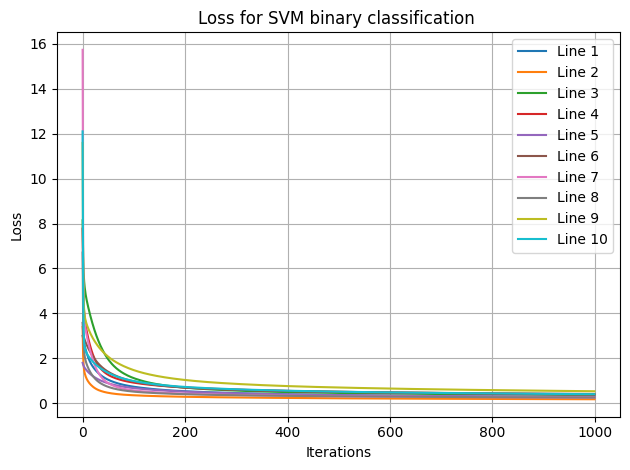

In [ ]:
learned_binary_classifers = []
for i in range(10):
    w, b, cost_history = SVM(X_train, y_train, digit=i, hinge_loss=hinge_loss)
    learned_binary_classifers.append((w,b))
    print(f"Cost of classifer for class {i}: {cost_history[-1]}")
    plt.plot(cost_history, label=f'Line {i+1}')

plt.title('Loss for SVM binary classification ')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()  # Show legend to identify each line

plt.grid(True)  # Optional: Add a grid for easier visualization
plt.tight_layout()  # Adjust the layout to make room for the legend
plt.show()



#### **Q8**) [[***BONUS*** 0.4%]](https://) Implement the one-versus-all multiway classifier using the binary classifiers you implemented above. You are free to code this up in your preferred style. However, make sure that your implementation includes a function that takes an array of feature vectors for the test set and an array of learned model parameters. This classifier should return an array of predicted labels for the input test data.

In [ ]:
def fusion_rule(x, w, b):
  return (b + np.dot(x.T, w)) / (np.dot(w,w))


def one_versus_all_classifier(X_test, w):
  y_test = np.zeros(X_test.shape[0])

  for example_num, x in enumerate(X_test): # loop over each example in the test example

    label_so_far = -1
    curr_max_dist = 0

    # loop over all the learned models for the different classes
    for label, (w,b) in enumerate(learned_binary_classifers):
      # compute the max signed distance
      max_dist = fusion_rule(x, w, b)

      if max_dist > curr_max_dist:
        curr_max_dist = max_dist
        label_so_far = label

    y_test[example_num] = label_so_far


  return y_test

In [ ]:
preds = one_versus_all_classifier(X_test, learned_binary_classifers)

#### **Q9**) [[***BONUS*** 0.1%]](https://) Calculate the accuracy of the test set using your one-versus-all classifier implemented above. Use the function implemented in Q2.



In [ ]:
#Your code here
calculate_accuracy(preds, y_test)

0.771